# Q-Learning on the OpenAI Gym Taxi-v3 Environment
This notebook demonstrates how to solve the Taxi-v3 environment using the Q-learning algorithm.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


## Environment Setup
We use the Taxi-v3 environment from OpenAI Gym, where a taxi must pick up and drop off a passenger at designated locations on a grid.

In [2]:
env = gym.make('Taxi-v3')
state = env.reset()
print(f"Environment initialized. Number of states: {env.observation_space.n}")
print(f"Number of actions: {env.action_space.n}")

Environment initialized. Number of states: 500
Number of actions: 6


## Taxi-v3 Problem Setup

In the Taxi-v3 environment, an agent (“taxi”) must navigate a 5×5 grid world, pick up a passenger at one of four designated pickup locations, and drop them off at one of four drop-off locations. The MDP is defined as follows:

- **State space $S$**  
  Each state $s$ encodes:  
  1. Taxi row (0–4)  
  2. Taxi column (0–4)  
  3. Passenger location (4 pickup spots + “in taxi” = 5 possibilities)  
  4. Destination index (4 possible drop-off spots)  
  This yields  
  $$
    5 \times 5 \times 5 \times 4 \;=\; 500
  $$  
  distinct states.

- **Action space $A$**  
  There are 6 discrete actions:  
  1. Move south  
  2. Move north  
  3. Move east  
  4. Move west  
  5. Pick up passenger  
  6. Drop off passenger  

- **Transition dynamics $P(s' \mid s, a)$**  
  - Moving off the grid leaves the taxi in the same cell.  
  - “Pick up” succeeds only if the taxi is at the passenger’s location; otherwise it incurs an illegal-pickup penalty.  
  - “Drop off” succeeds only when the taxi is at the correct destination *and* the passenger is aboard; otherwise it incurs an illegal-dropoff penalty.

- **Reward function $R(s,a)$**  
  - $-1$ per time step (to encourage efficiency)  
  - $+20$ for a successful drop-off  
  - $-10$ for an illegal pick-up or drop-off attempt

- **Episode termination**  
  The episode ends when the passenger is successfully delivered (terminal state). A maximum step limit (default 200 steps) can also truncate the episode.

- **Objective**  
  Learn a policy $\pi(s)$ that maximizes the expected cumulative discounted reward  
  $$
    \mathbb{E}\Bigl[\sum_{t=0}^\infty \gamma^t \, r_t\Bigr],
  $$  
  where $\gamma \in [0,1]$ is the discount factor and $r_t$ is the reward received at time $t$.


## Markov Decision Process Formulation
The environment is modeled as an MDP $(S, A, P, R, \gamma)$ where:
- $S$: finite set of states (taxi location, passenger location, destination)
- $A$: finite set of actions (move south, north, east, west, pick up, drop off)
- $P(s'\mid s,a)$: transition probabilities determined by the environment's dynamics
- $R(s,a)$: reward function (e.g. -1 per step, +20 for successful dropoff, -10 for illegal pick/drop)
- $\gamma$: discount factor for future rewards

## Q-Learning Algorithm
Q-learning is an off-policy TD control algorithm. At each step:
$$
Q(s,a) \leftarrow Q(s,a) + \alpha \bigl[r + \gamma \max_{a'} Q(s',a') - Q(s,a)\bigr]
$$
where:
- $\alpha$ is the learning rate
- $\gamma$ is the discount factor
- $r$ is the immediate reward
- $s'$ is the next state

## Implementing Q-Learning
We create a function `q_learning(env, num_episodes, alpha, gamma, epsilon, epsilon_decay)`
that returns the learned Q-table and a record of rewards per episode.

In [3]:
def q_learning(env, num_episodes, alpha, gamma, epsilon, epsilon_decay):
    n_states  = env.observation_space.n
    n_actions = env.action_space.n
    Q         = np.zeros((n_states, n_actions))
    rewards   = []

    for ep in range(num_episodes):
        state, _ = env.reset()      
        total_reward = 0
        done = False

        while not done:
            # ε-greedy action
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Q-update
            best_next = np.max(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * best_next - Q[state, action])

            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        epsilon *= epsilon_decay

    return Q, rewards


## Training the Agent
We train for 5,000 episodes with learning rate $\alpha=0.1$, discount $\gamma=0.99$,
initial exploration rate $\epsilon=1.0$ decayed by $\epsilon_{decay}=0.995$.

In [4]:
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
num_episodes = 5000
Q, rewards = q_learning(env, num_episodes, alpha, gamma, epsilon, epsilon_decay)
print(f"Average reward over last 100 episodes: {np.mean(rewards[-100:]):.2f}")

/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Average reward over last 100 episodes: 8.07


### Learning Curve
Plot total reward per episode to observe learning progress.

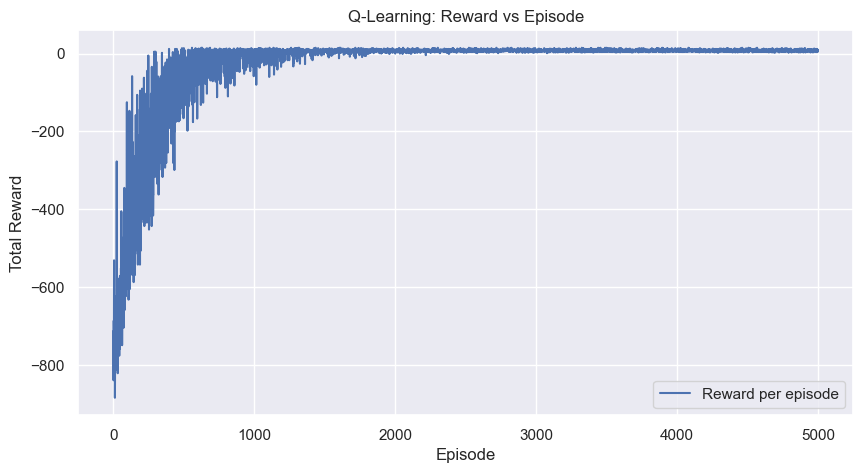

In [5]:
plt.figure(figsize=(10,5))
plt.plot(rewards, label='Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning: Reward vs Episode')
plt.legend()
plt.show()

## Policy Evaluation
Run the learned policy for 100 episodes and compute average reward.

In [6]:
def evaluate_policy(env, Q, episodes=100):
    total_reward = 0
    
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        
        while not done:
            action = np.argmax(Q[state])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            state = next_state
            total_reward += reward
            
    return total_reward / episodes

avg_reward = evaluate_policy(env, Q)
print(f"Average reward over 100 evaluation episodes: {avg_reward:.2f}")

Average reward over 100 evaluation episodes: 8.02


## Discussion
- The Q-learning agent learns to pick up and drop off the passenger efficiently,
  maximizing the total reward.
- The reward curve shows improvement as exploration decays and Q-values converge.
- Hyperparameters such as $\alpha$, $\gamma$, and $\epsilon$ decay rate
  impact the speed and stability of learning.